In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pixelfly.runtime import PixelflyBoard, Mode, BinMode, PixelDepth
from analyze_spots import GridSpotAnalyzer
from homogenize import homogenize
from experiment.session import get_standard_experiment_session

In [2]:
pixelfly = PixelflyBoard(
    name="pixelfly",
    board_number=0,
    mode=Mode.SW_TRIGGER | Mode.ASYNC_SHUTTER,
    exp_time=30,
    hbin=BinMode.BIN_1X,
    vbin=BinMode.BIN_1X,
    gain=False,
    bit_pix=PixelDepth.BITS_12,
)

with pixelfly:
    pixelfly.start_acquisition()

    picture = pixelfly.read_image(1000).astype(float)
    pixelfly.stop_acquisition()


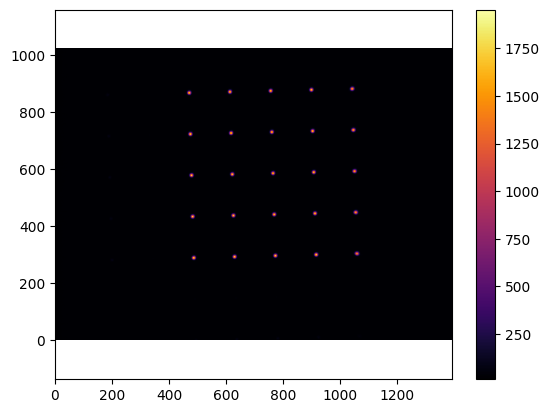

In [12]:
plt.imshow(picture.T, origin="lower", cmap = "inferno")
plt.axis("equal")
plt.colorbar()

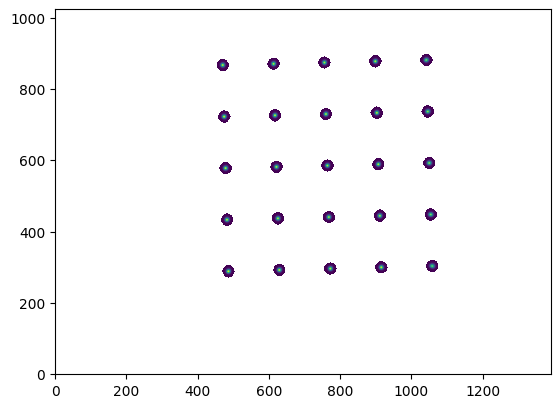

In [13]:
n_rows=5
n_cols=5
m = GridSpotAnalyzer(n_rows, n_cols)
im = m.register_regions_of_interest(picture, relative_threshold=0.27, radius=20)

plt.figure()
plt.imshow(im.T, origin="lower")

intensities = m.compute_intensity_matrix(picture)

In [5]:
(np.max(intensities) - np.min(intensities)) / np.mean(intensities) * 1e2

7.17225847822172

(array([3., 2., 2., 4., 8., 2., 1., 2., 0., 1.]),
 array([0.97065876, 0.97783102, 0.98500328, 0.99217553, 0.99934779,
        1.00652005, 1.01369231, 1.02086457, 1.02803683, 1.03520909,
        1.04238134]),
 <BarContainer object of 10 artists>)

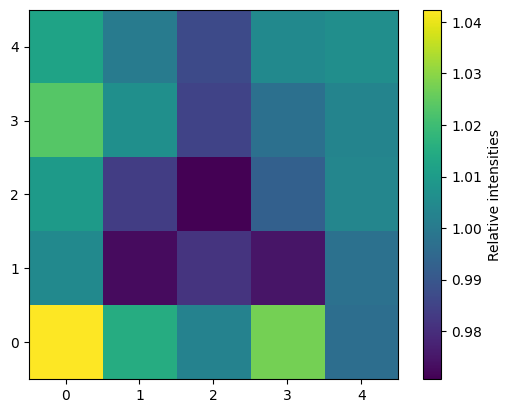

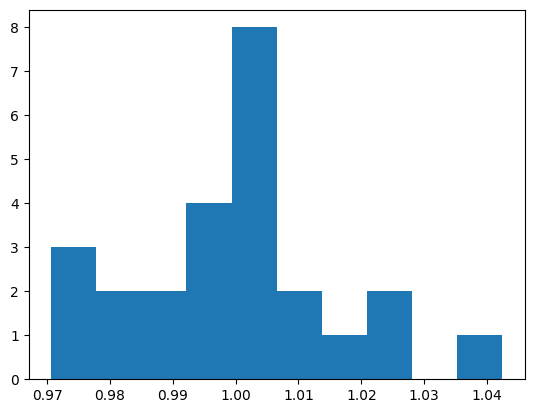

In [14]:
plt.figure()
plt.imshow(intensities.T[::-1, ::] / np.mean(intensities), origin="lower")
cb = plt.colorbar()
cb.set_label("Relative intensities")
plt.figure()
plt.hist((intensities.T / np.mean(intensities)).flatten())

In [7]:
session = get_standard_experiment_session()
with session.activate():
    experiment_config = session.get_current_experiment_config()
    arranger_config = experiment_config.get_device_config("Tweezer arranger")
    tweezer_config = arranger_config["5x5 tweezers"]

In [8]:
w = np.ones((5,5))
w[:,0]*=0.5
intensities, amplitudes_x, amplitudes_y = homogenize(tweezer_config, beta=0.3,exposure=30,roi_radius=20, relative_threshold=0.27)


DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X amplitude: 368 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y amplitude: 368 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:0
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:step_name='step_0'
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:step_index=0
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:mask & spcm.SPCSEQ_NEXTSTEPMASK=0
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X amplitude: 368 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y amplitude: 368 mV
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:0
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:step_name='step_0'
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:step_index=0
DEBUG:spectum_awg_m4i66xx_x8.runtime.runtime:mask & spcm.SPCSEQ_NEXTSTEPMASK=0
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
DEBUG:spectum_awg_m4i66xx_

In [10]:
best_shot = np.argmin(np.var(np.var(intensities, axis=-1), axis=-1))
tweezer_config.amplitudes_x = amplitudes_x[best_shot]
tweezer_config.amplitudes_y = amplitudes_y[best_shot]


In [11]:
with session.activate():
    experiment_config = session.get_current_experiment_config()
    arranger_config = experiment_config.get_device_config("Tweezer arranger")
    arranger_config["5x5 tweezers"] = tweezer_config
    experiment_config.set_device_config("Tweezer arranger", arranger_config)
    new_config_name = session.add_experiment_config(experiment_config)
    session.set_current_experiment_config(new_config_name)